In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


#### In this Week 4's Mini Project, we will analyze data about Twitter texts. Our goal is to classify whether the Twitter texts indicating disasters or not. The data is from: https://www.kaggle.com/competitions/nlp-getting-started. Our mission is to train a Recurrent Neural Network model based on training dataset and classify the twitters in testing dataset. We will use BiLSTM model to do the classification mission.

In [2]:
os.environ["TF_USE_LEGACY_KERAS"] = "1"    #use Keras2 version

#### Install necessary packages.

In [3]:
import random
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torchtext
import tensorflow as tf
import keras
import shutil

2024-06-02 10:21:59.475013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 10:21:59.475102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 10:21:59.611329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Set a random seed to ensure reproducibility.

In [4]:
def set_seed(seed_value=3407):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    tf.config.experimental.enable_op_determinism()

# 1. Data Preprocessing and EDA

#### See the training dataset.

In [5]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv',index_col=None)
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### See if there are duplications.

In [9]:
duplicates0 = df_train.duplicated()
df_train[duplicates0]

,id,keyword,location,text,target


#### We can see that there are no duplications.

#### From the above 5 cells, we can see that the training dataset contains 7613 texts. The target is 1 or 0 that stands for disaster or not.

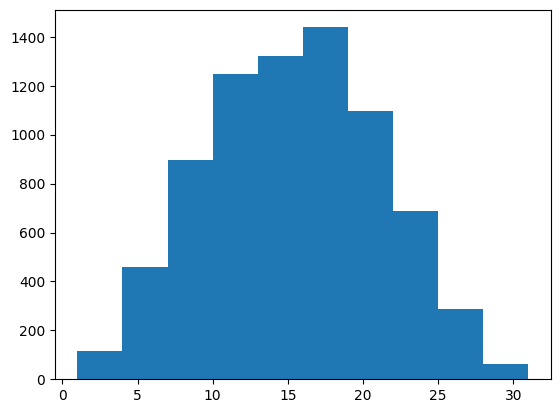

In [10]:
word_count = [len(x0) for x0 in list(df_train['text'].str.split())]
plt.hist(word_count)
plt.show()

In [11]:
word_count

[13,
 7,
 22,
 8,
 16,
 18,
 14,
 15,
 12,
 10,
 9,
 27,
 12,
 7,
 11,
 3,
 3,
 3,
 5,
 3,
 3,
 4,
 2,
 4,
 1,
 6,
 5,
 3,
 2,
 4,
 2,
 5,
 10,
 9,
 7,
 13,
 21,
 8,
 19,
 5,
 8,
 11,
 24,
 6,
 14,
 16,
 13,
 10,
 8,
 27,
 9,
 11,
 18,
 10,
 15,
 19,
 13,
 22,
 24,
 16,
 17,
 18,
 15,
 23,
 10,
 8,
 19,
 27,
 12,
 16,
 18,
 14,
 18,
 4,
 15,
 12,
 9,
 9,
 16,
 18,
 27,
 19,
 17,
 14,
 12,
 17,
 8,
 24,
 25,
 6,
 6,
 8,
 12,
 9,
 4,
 26,
 22,
 21,
 10,
 22,
 17,
 20,
 8,
 20,
 16,
 11,
 16,
 8,
 24,
 11,
 11,
 11,
 18,
 2,
 16,
 16,
 16,
 9,
 16,
 16,
 21,
 16,
 23,
 8,
 16,
 19,
 26,
 16,
 27,
 11,
 5,
 2,
 21,
 19,
 14,
 18,
 18,
 20,
 14,
 18,
 17,
 20,
 9,
 10,
 22,
 10,
 18,
 20,
 13,
 13,
 22,
 18,
 13,
 10,
 10,
 11,
 18,
 11,
 18,
 18,
 17,
 25,
 10,
 14,
 20,
 5,
 13,
 21,
 12,
 7,
 21,
 22,
 11,
 20,
 13,
 9,
 19,
 10,
 13,
 13,
 18,
 13,
 13,
 11,
 5,
 11,
 13,
 8,
 21,
 14,
 11,
 10,
 13,
 13,
 22,
 12,
 11,
 11,
 9,
 9,
 12,
 11,
 11,
 11,
 11,
 11,
 18,
 11,
 13,
 17,
 19,

#### We can see that the range of number of words is from 1 to 31, most texts' number of words is from 5 to 20.

In [12]:
keyword0 = [x0 for x0 in df_train['keyword'].tolist() if pd.isna(x0) == False]
keyword0 = list(set(keyword0))
len(keyword0)

221

In [13]:
location0 = [x0 for x0 in df_train['location'].tolist() if pd.isna(x0) == False]
location0 = list(set(location0))
len(location0)

3341

#### Only 221 twitters have keywords and only 3341 twitters have locations.

In [14]:
category_dict = {}
for x0 in list(set(df_train['target'].tolist())):
    category_dict[x0] = len(df_train[df_train['target']==x0])
category_dict

{0: 4342, 1: 3271}

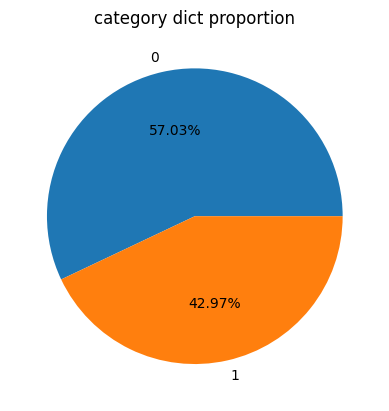

In [15]:
plt.title('category dict proportion')
plt.pie(category_dict.values(),labels=category_dict.keys(),autopct='%.2f%%')
plt.show()

#### From the pie chart above, we can see that roughly 57% of training samples, 4342, are not disaster twitters and roughly 43%, 3271, are disaster twitters.

# 2. Data Cleaning

#### In the data cleaning step, we will remove punctuation marks, numbers, stop words, URL, non-English characters, extra spaces and extremely short sentences.

In [16]:
#show punctuation marks
punctuation_marks = [x0 for x0 in string.punctuation if x0 not in ["'",'-']]
punctuation_marks = punctuation_marks + [' -','- '," '","' "]

punctuation_marks

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 ' -',
 '- ',
 " '",
 "' "]

In [17]:
#show stop words
list(ENGLISH_STOP_WORDS)

['beyond',
 'also',
 'always',
 'ours',
 'nobody',
 'himself',
 'about',
 'mine',
 'these',
 'ltd',
 'has',
 'could',
 'it',
 'co',
 'alone',
 'so',
 'everyone',
 'thus',
 'take',
 'each',
 'might',
 'an',
 'much',
 'along',
 'thence',
 'go',
 'only',
 'myself',
 'perhaps',
 'per',
 'are',
 'i',
 'found',
 'noone',
 'several',
 'sincere',
 'else',
 'every',
 'serious',
 'ever',
 'former',
 'both',
 'thereafter',
 'nothing',
 'hereupon',
 'see',
 'whoever',
 'because',
 'into',
 'than',
 'everywhere',
 'became',
 'very',
 'cant',
 'inc',
 'ie',
 'against',
 'whose',
 'hundred',
 'fifty',
 'was',
 'us',
 'themselves',
 'throughout',
 'get',
 'some',
 'all',
 'third',
 'amount',
 'beforehand',
 'con',
 'fifteen',
 'find',
 'we',
 'still',
 'before',
 'while',
 'fill',
 'its',
 'such',
 'below',
 'wherever',
 'thin',
 'top',
 'yourselves',
 'down',
 'again',
 'here',
 'nor',
 'neither',
 'whom',
 'upon',
 'least',
 'first',
 'moreover',
 'within',
 'seem',
 'their',
 'own',
 'whenever',
 '

In [18]:
#remove URL
for i in df_train.index:
    temp0 = [elt0 for elt0 in df_train.loc[i,'text'].split() if 'http' not in elt0]
    temp1 = ' '.join(temp0)
    df_train.loc[i,'text'] = temp1

df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [19]:
#remove punctuation marks
for x0 in punctuation_marks:
    df_train['text'] = df_train['text'].str.replace(x0,' ')
#remove numbers
for x0 in string.digits:
    df_train['text'] = df_train['text'].str.replace(x0,' ')
#remove stop words
for i in df_train.index:
    temp0 = [elt0 for elt0 in df_train.loc[i,'text'].split() if elt0.lower() not in list(ENGLISH_STOP_WORDS)]
    temp1 = ' '.join(temp0)
    df_train.loc[i,'text'] = temp1

df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Deeds Reason earthquake ALLAH Forgive,1
1,4,NaN,NaN,Forest near La Ronge Sask Canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders Cal...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,aria ahrary TheTawniest control wild fires Cal...,1
7610,10871,NaN,NaN,M UTC km S Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating e-bike collided car Littl...,1


In [20]:
#collect non-English characters
char0 = []
for i in df_train.index:
    #
    x0 = df_train.loc[i,'text']
    x0 = x0.replace(' ','')
    char0 = char0 + list(x0)
    #
    x0 = df_train.loc[i,'keyword']
    x0 = str(x0)
    x0 = x0.replace(' ','')
    char0 = char0 + list(x0)
    #
    x0 = df_train.loc[i,'location']
    x0 = str(x0)
    x0 = x0.replace(' ','')
    char0 = char0 + list(x0)
    #
    char0 = list(set(char0))
char0 = [x0 for x0 in char0 if x0 not in string.ascii_letters]
char0 = [x0 for x0 in char0 if x0 not in string.punctuation]
char0 = [x0 for x0 in char0 if x0 not in string.digits]

char0

['á',
 '\x9d',
 '©',
 'Â',
 'Ê',
 '¼',
 'ª',
 'Ç',
 'À',
 'È',
 '¡',
 '\n',
 'Û',
 '«',
 'Ò',
 '\x90',
 '¤',
 'Ñ',
 'ø',
 '\x89',
 '£',
 'Á',
 'ã',
 'å',
 'â',
 '\x81',
 'ü',
 'ä',
 '¢',
 '¨',
 '÷',
 '¬',
 'Ï',
 'Ì',
 '´',
 '±',
 'Ó',
 '¦']

In [21]:
#remove non-English characters
for x0 in char0:
    df_train['text'] = df_train['text'].str.replace(x0,' ')

df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Deeds Reason earthquake ALLAH Forgive,1
1,4,NaN,NaN,Forest near La Ronge Sask Canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders Cal...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,aria ahrary TheTawniest control wild fires Cal...,1
7610,10871,NaN,NaN,M UTC km S Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating e-bike collided car Littl...,1


In [22]:
#remove extra spaces
for i in df_train.index:
    df_train.loc[i,'text'] = ' '.join(df_train.loc[i,'text'].split())

df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Deeds Reason earthquake ALLAH Forgive,1
1,4,NaN,NaN,Forest near La Ronge Sask Canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders Cal...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,aria ahrary TheTawniest control wild fires Cal...,1
7610,10871,NaN,NaN,M UTC km S Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating e-bike collided car Littl...,1


In [23]:
#delete extremely short sentences
df_train = df_train.drop(index=df_train[df_train['text'].str.len()==0].index.tolist())

df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Deeds Reason earthquake ALLAH Forgive,1
1,4,NaN,NaN,Forest near La Ronge Sask Canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders Cal...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,aria ahrary TheTawniest control wild fires Cal...,1
7610,10871,NaN,NaN,M UTC km S Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating e-bike collided car Littl...,1


#### Then we use almost the same procedures to treat the testing texts.

In [24]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv',index_col=None)
#remove URL
for i in df_test.index:
    temp0 = [elt0 for elt0 in df_test.loc[i,'text'].split() if 'http' not in elt0]
    temp1 = ' '.join(temp0)
    df_test.loc[i,'text'] = temp1
#remove punctuation marks
for x0 in punctuation_marks:
    df_test['text'] = df_test['text'].str.replace(x0,' ')
#remove numbers
for x0 in string.digits:
    df_test['text'] = df_test['text'].str.replace(x0,' ')
#remove stop words
for i in df_test.index:
    temp0 = [elt0 for elt0 in df_test.loc[i,'text'].split() if elt0.lower() not in list(ENGLISH_STOP_WORDS)]
    temp1 = ' '.join(temp0)
    df_test.loc[i,'text'] = temp1
#collect non-English characters
char0 = []
for i in df_test.index:
    #
    x0 = df_test.loc[i,'text']
    x0 = x0.replace(' ','')
    char0 = char0 + list(x0)
    #
    x0 = df_test.loc[i,'keyword']
    x0 = str(x0)
    x0 = x0.replace(' ','')
    char0 = char0 + list(x0)
    #
    x0 = df_test.loc[i,'location']
    x0 = str(x0)
    x0 = x0.replace(' ','')
    char0 = char0 + list(x0)
    #
    char0 = list(set(char0))
char0 = [x0 for x0 in char0 if x0 not in string.ascii_letters]
char0 = [x0 for x0 in char0 if x0 not in string.punctuation]
char0 = [x0 for x0 in char0 if x0 not in string.digits]
#remove non-English characters
for x0 in char0:
    df_test['text'] = df_test['text'].str.replace(x0,' ')
#remove extra spaces
for i in df_test.index:
    df_test.loc[i,'text'] = ' '.join(df_test.loc[i,'text'].split())
#delete extremely short sentences
#df_test = df_test.drop(index=df_test[df_test['text'].str.len()==0].index.tolist())

df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different cities stay safe
2,3,NaN,NaN,forest spot pond geese fleeing street save
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills China Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS...
3259,10865,NaN,NaN,Storm RI worse hurricane city amp hardest hit ...
3260,10868,NaN,NaN,Green Line derailment Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO


# 3. Word Vectors and Embedding Matrix

#### We firstly tokenize all the texts.

In [25]:
all_text = df_train['text'].tolist()+df_test['text'].tolist()

all_text

['Deeds Reason earthquake ALLAH Forgive',
 'Forest near La Ronge Sask Canada',
 'residents asked shelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders California',
 'Just got sent photo Ruby Alaska smoke wildfires pours school',
 'RockyFire Update California Hwy closed directions Lake County CAfire wildfires',
 'flood disaster Heavy rain causes flash flooding streets Manitou Colorado Springs areas',
 "I'm hill woods",
 "There's emergency evacuation happening building street",
 "I'm afraid tornado coming area",
 'people died heat wave far',
 'Haha South Tampa getting flooded hah WAIT SECOND LIVE SOUTH TAMPA GONNA GONNA FVCK flooding',
 "raining flooding Florida TampaBay Tampa days I've lost count",
 'Flood Bago Myanmar arrived Bago',
 'Damage school bus multi car crash BREAKING',
 "What's man",
 'love fruits',
 'Summer lovely',
 'car fast',
 'goooooooaaaaaal',
 'ridiculous',
 'London cool',
 'Love skiing',
 'wonderful day

#### Here, we don't know how the number of words is, so we just set a substantially large number, then adjust it later.

In [26]:
tokenizer=Tokenizer(num_words=999999)
tokenizer.fit_on_texts(all_text)
sequence=tokenizer.texts_to_sequences(all_text)

sequence

[[5458, 661, 135, 1582, 3503],
 [71, 97, 689, 8061, 8062, 1223],
 [1378, 1293, 1873, 575, 8063, 1583, 150, 1873, 575, 1474, 1055],
 [8, 4222, 1164, 150, 1474, 30],
 [3, 23, 1294, 164, 5459, 2029, 158, 1164, 8064, 98],
 [2937, 265, 30, 1475, 709, 8065, 1056, 277, 5460, 1164],
 [94, 13, 710, 165, 912, 711, 174, 1584, 8066, 913, 2548, 1379],
 [4, 1874, 4223],
 [350, 10, 150, 1057, 441, 520],
 [4, 2030, 409, 136, 192],
 [8, 396, 142, 266, 442],
 [739,
  423,
  2549,
  121,
  2550,
  4224,
  529,
  511,
  87,
  423,
  2549,
  151,
  151,
  8067,
  174],
 [3504, 174, 1585, 8068, 2549, 456, 206, 612, 3505],
 [94, 5461, 836, 1380, 5461],
 [126, 98, 351, 2938, 46, 22, 212],
 [592, 29],
 [35, 5462],
 [137, 1476],
 [46, 662],
 [8069],
 [3506],
 [870, 478],
 [35, 8070],
 [2268, 24],
 [8071],
 [58, 54, 1058, 105],
 [1224, 222],
 [35, 2551],
 [8072],
 [2, 4225],
 [243],
 [8073, 2552, 1875, 443],
 [530, 690, 710, 1059, 19],
 [8074, 212, 7, 1721, 663, 159, 443, 914],
 [1477, 159, 443],
 [1876, 84, 100

In [27]:
word_index=tokenizer.word_index

word_index

{'amp': 1,
 'like': 2,
 'just': 3,
 "i'm": 4,
 'new': 5,
 's': 6,
 'news': 7,
 'people': 8,
 "it's": 9,
 'emergency': 10,
 "don't": 11,
 'video': 12,
 'disaster': 13,
 'police': 14,
 'u': 15,
 'time': 16,
 'body': 17,
 'suicide': 18,
 'rt': 19,
 'storm': 20,
 'burning': 21,
 'crash': 22,
 'got': 23,
 'day': 24,
 'attack': 25,
 'know': 26,
 'fires': 27,
 'buildings': 28,
 'man': 29,
 'california': 30,
 'going': 31,
 'bomb': 32,
 'w': 33,
 'nuclear': 34,
 'love': 35,
 'world': 36,
 'hiroshima': 37,
 'pm': 38,
 'year': 39,
 'dead': 40,
 'today': 41,
 'youtube': 42,
 'life': 43,
 'watch': 44,
 'old': 45,
 'car': 46,
 'm': 47,
 'killed': 48,
 'train': 49,
 'think': 50,
 'accident': 51,
 'make': 52,
 'war': 53,
 "can't": 54,
 'good': 55,
 'say': 56,
 'gt': 57,
 'way': 58,
 't': 59,
 'families': 60,
 'years': 61,
 'need': 62,
 'want': 63,
 'best': 64,
 'bombing': 65,
 'mass': 66,
 'did': 67,
 'home': 68,
 'right': 69,
 'collapse': 70,
 'forest': 71,
 'water': 72,
 'death': 73,
 'army': 74,
 '

In [28]:
len(word_index)

20575

#### We can see that there is 20575 different words in all texts (including training and testing texts). So, we adjust the num_words parameter correspondingly and tokenize all the texts again.

In [29]:
tokenizer=Tokenizer(num_words=20575)
tokenizer.fit_on_texts(all_text)
sequence=tokenizer.texts_to_sequences(all_text)
word_index=tokenizer.word_index

word_index

{'amp': 1,
 'like': 2,
 'just': 3,
 "i'm": 4,
 'new': 5,
 's': 6,
 'news': 7,
 'people': 8,
 "it's": 9,
 'emergency': 10,
 "don't": 11,
 'video': 12,
 'disaster': 13,
 'police': 14,
 'u': 15,
 'time': 16,
 'body': 17,
 'suicide': 18,
 'rt': 19,
 'storm': 20,
 'burning': 21,
 'crash': 22,
 'got': 23,
 'day': 24,
 'attack': 25,
 'know': 26,
 'fires': 27,
 'buildings': 28,
 'man': 29,
 'california': 30,
 'going': 31,
 'bomb': 32,
 'w': 33,
 'nuclear': 34,
 'love': 35,
 'world': 36,
 'hiroshima': 37,
 'pm': 38,
 'year': 39,
 'dead': 40,
 'today': 41,
 'youtube': 42,
 'life': 43,
 'watch': 44,
 'old': 45,
 'car': 46,
 'm': 47,
 'killed': 48,
 'train': 49,
 'think': 50,
 'accident': 51,
 'make': 52,
 'war': 53,
 "can't": 54,
 'good': 55,
 'say': 56,
 'gt': 57,
 'way': 58,
 't': 59,
 'families': 60,
 'years': 61,
 'need': 62,
 'want': 63,
 'best': 64,
 'bombing': 65,
 'mass': 66,
 'did': 67,
 'home': 68,
 'right': 69,
 'collapse': 70,
 'forest': 71,
 'water': 72,
 'death': 73,
 'army': 74,
 '

In [30]:
len(word_index)

20575

In [31]:
#see the sequence
sequence

[[5458, 661, 135, 1582, 3503],
 [71, 97, 689, 8061, 8062, 1223],
 [1378, 1293, 1873, 575, 8063, 1583, 150, 1873, 575, 1474, 1055],
 [8, 4222, 1164, 150, 1474, 30],
 [3, 23, 1294, 164, 5459, 2029, 158, 1164, 8064, 98],
 [2937, 265, 30, 1475, 709, 8065, 1056, 277, 5460, 1164],
 [94, 13, 710, 165, 912, 711, 174, 1584, 8066, 913, 2548, 1379],
 [4, 1874, 4223],
 [350, 10, 150, 1057, 441, 520],
 [4, 2030, 409, 136, 192],
 [8, 396, 142, 266, 442],
 [739,
  423,
  2549,
  121,
  2550,
  4224,
  529,
  511,
  87,
  423,
  2549,
  151,
  151,
  8067,
  174],
 [3504, 174, 1585, 8068, 2549, 456, 206, 612, 3505],
 [94, 5461, 836, 1380, 5461],
 [126, 98, 351, 2938, 46, 22, 212],
 [592, 29],
 [35, 5462],
 [137, 1476],
 [46, 662],
 [8069],
 [3506],
 [870, 478],
 [35, 8070],
 [2268, 24],
 [8071],
 [58, 54, 1058, 105],
 [1224, 222],
 [35, 2551],
 [8072],
 [2, 4225],
 [243],
 [8073, 2552, 1875, 443],
 [530, 690, 710, 1059, 19],
 [8074, 212, 7, 1721, 663, 159, 443, 914],
 [1477, 159, 443],
 [1876, 84, 100

#### Next, we see the maximum length of sentences.

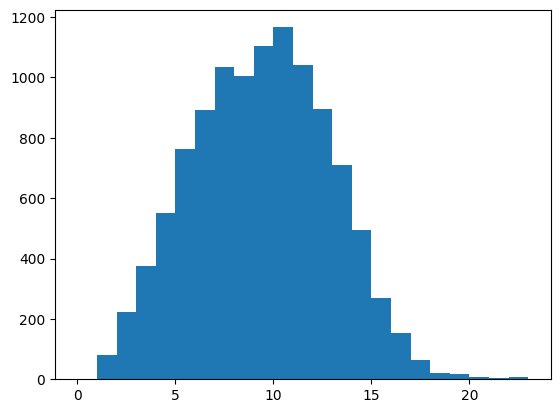

0.9500689655172414

In [32]:
#see sentence length
word_count = [len(x0) for x0 in sequence]
plt.hist(word_count,bins=max(word_count))
plt.show()
len([x0 for x0 in word_count if x0<=14])/len(word_count)

#### We can see most of texts' numbers of words are equal to or less than 14, so we set maximum length of a sentence as 14.

#### We set the parameter ‘padding’ as ‘pre’, which implies that if the number of words of sentences is shorter than 14, the shortcomings at the front of sentences will be filled with 0. Of course, if the number of words of sentences is larger than 14, we will keep the last 14 words only.

In [33]:
all_data=pad_sequences(sequence,maxlen=14,padding='pre')

all_data

array([[   0,    0,    0, ...,  135, 1582, 3503],
       [   0,    0,    0, ..., 8061, 8062, 1223],
       [   0,    0,    0, ...,  575, 1474, 1055],
       ...,
       [   0,    0,    0, ...,  403,  307,  664],
       [   0,    0,    0, ...,  138, 1577, 1715],
       [   0,    0,    0, ...,   10,  140, 2883]], dtype=int32)

#### Then we split the training, validation and testing data. We use training data to train the model, and we use the validation data to select a trained model. Then we predict the classification of testing data using selected trained model.

In [34]:
train_data = all_data[:len(df_train)]
test_data = all_data[len(df_train):]

In [35]:
set_seed()
X_train,X_val,y_train,y_val=train_test_split(train_data,df_train['target'],test_size=0.3)

In [36]:
temp0=[]
for x0 in y_train:
    if x0==1:
        temp0.append([0,1])
    else:
        temp0.append([1,0])
y_train=np.array(temp0)
temp0=[]
for x0 in y_val:
    if x0==1:
        temp0.append([0,1])
    else:
        temp0.append([1,0])
y_val=np.array(temp0)

#### Then we build embedding weights matrix.

#### We use pre-trained 200-dimension word-to-vector model to build the embedding weights matrix. It is named ‘twitter.27B’ and all words are from twitter texts.

In [37]:
%%time
#download the word-to-vector
w_2_v = torchtext.vocab.GloVe(name='twitter.27B',dim=200,cache='/kaggle/working/glove')

/kaggle/working/glove/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [02:21<00:00, 8453.94it/s]


CPU times: user 2min 53s, sys: 10.4 s, total: 3min 3s
Wall time: 7min 39s


#### We set the dimension of the embedding matrix as (20575+1)×200. 200 is the dimension of word-to-vectors. 20575 is the number of different words. However, what is the remaining 1? It means the padding of the words.

In [38]:
embedding_matrix=np.zeros((20575+1,200))
for k,v in word_index.items():
    embedding_matrix[v]=w_2_v[k]
    
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12293   ,  0.20598   ,  0.056996  , ...,  0.45835999,
         0.13722   ,  0.66996998],
       [-0.015537  ,  0.11158   , -0.23599   , ..., -0.037577  ,
        -0.13539   ,  0.45965001],
       ...,
       [ 0.60323   ,  0.38554999, -0.014256  , ...,  0.27281001,
         0.35587999, -0.099306  ],
       [ 0.36585999, -0.31378001,  0.73769999, ...,  0.01626   ,
         0.1302    , -0.16039   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [39]:
#see the dimension
embedding_matrix.shape

(20576, 200)

#### Remove used data to save disk volume.

In [40]:
shutil.rmtree('/kaggle/working/glove')

# 4. Model Training and Prediction

#### We use BiLSTM model to do the classification.

#### A bidirectional LSTM (BiLSTM) layer is an RNN layer that learns bidirectional long-term dependencies between time steps of time-series or sequence data. These dependencies can be useful when you want the RNN to learn from the complete time series at each time step. (Citation: https://www.mathworks.com/help/deeplearning/ref/nnet.cnn.layer.bilstmlayer.html)

#### Here, we set a 4-layer BiLSTM model, each layer is a bidirectional layer and has 128 nodes. The fully connected layer’s activation is ReLu.

In [41]:
model0=tf.keras.models.Sequential()
model0.add(tf.keras.layers.Embedding(input_dim=20575+1,output_dim=200,input_length=14,weights=[embedding_matrix],trainable=False))
model0.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,return_sequences=True,dropout=0.2,seed=None)))
model0.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,return_sequences=True,dropout=0.2,seed=None)))
model0.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,return_sequences=True,dropout=0.2,seed=None)))
model0.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,return_sequences=False,dropout=0.2,seed=None)))
model0.add(tf.keras.layers.Dense(128*2,activation=tf.nn.elu))
model0.add(tf.keras.layers.Dense(2,activation=tf.nn.relu))

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 200)           4115200   
                                                                 
 bidirectional (Bidirection  (None, 14, 256)           336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 14, 256)           394240    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 14, 256)           394240    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                  

#### New a file to save trained models.

In [42]:
try:
    shutil.rmtree('/kaggle/working/')
except:
    None
os.mkdir('/kaggle/working/model_save/')

#### Set the callback. Save the model every 100 epochs and save the weights only.

In [43]:
my_callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/model_save/model_{epoch:02d}.h5',save_weights_only=True,period=100)]

#### Set the optimizer. We use Exponential Decay for the learning rate. The initial learning rate is 0.001, and it decays every 100 epochs and the decay rate is 0.995. The optimizer is RMSprop.

In [44]:
lr_schedule0=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_steps=100,decay_rate=0.995)
optimizer0=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule0)

#### Then we train the model for 5000 epochs. We set the batch size as 64 and set the metrics as accuracy and F1 score. The loss function is binary cross entropy loss. We use GPU instead of CPU to speed up.

In [45]:
%%time
set_seed()
model0.compile(optimizer=optimizer0,loss='binary_crossentropy',metrics=['accuracy',keras.metrics.F1Score()])
with tf.device('/gpu:0'):
    history0=model0.fit(X_train,y_train,epochs=5000,batch_size=64,validation_data=(X_val,y_val),callbacks=[my_callbacks])

Epoch 1/5000


I0000 00:00:1717324265.500259      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 [==============================] - 48s 69ms/step - loss: 4.4442 - accuracy: 0.4698 - f1_score: 0.3620 - val_loss: 0.6616 - val_accuracy: 0.7417 - val_f1_score: 0.4923
Epoch 2/5000
84/84 [==============================] - 1s 17ms/step - loss: 0.6757 - accuracy: 0.7357 - f1_score: 0.5904 - val_loss: 0.5357 - val_accuracy: 0.7811 - val_f1_score: 0.6370
Epoch 3/5000
84/84 [==============================] - 1s 17ms/step - loss: 0.6126 - accuracy: 0.7712 - f1_score: 0.6633 - val_loss: 0.9005 - val_accuracy: 0.8012 - val_f1_score: 0.6845
Epoch 4/5000
84/84 [==============================] - 1s 17ms/step - loss: 0.5654 - accuracy: 0.7714 - f1_score: 0.6962 - val_loss: 0.5104 - val_accuracy: 0.7863 - val_f1_score: 0.7063
Epoch 5/5000
84/84 [==============================] - 1s 17ms/step - loss: 0.5317 - accuracy: 0.7900 - f1_score: 0.7139 - val_loss: 1.0307 - val_accuracy: 0.8126 - val_f1_score: 0.7222
Epoch 6/5000
84/84 [==============================] - 1s 17ms/step - loss: 0.5063 - acc

#### See the outputs.

In [46]:
df0=pd.DataFrame(history0.history)

df0

,loss,accuracy,f1_score,val_loss,val_accuracy,val_f1_score
0,4.444224,0.469782,0.362037,0.661574,0.741681,0.492279
1,0.675686,0.735736,0.590438,0.535720,0.781086,0.636991
2,0.612586,0.771209,0.663347,0.900483,0.801226,0.684547
3,0.565443,0.771396,0.696221,0.510361,0.786340,0.706275
4,0.531672,0.789977,0.713950,1.030704,0.812609,0.722161
...,...,...,...,...,...,...
4995,0.057641,0.985360,0.925596,2.761369,0.798599,0.925597
4996,0.056439,0.983671,0.925597,2.761369,0.798599,0.925597
4997,0.058554,0.984610,0.925597,2.761369,0.798599,0.925597
4998,0.055183,0.984610,0.925597,2.761369,0.798599,0.925597


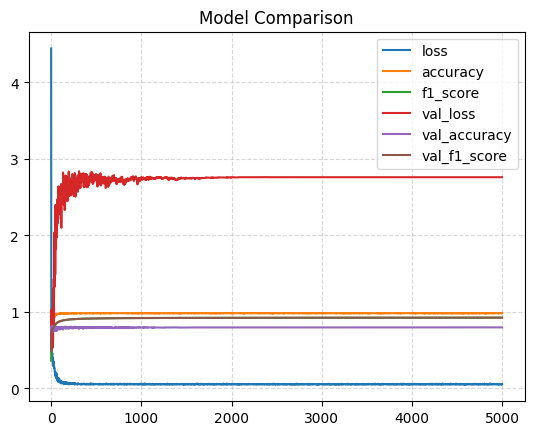

In [47]:
plt.title('Model Comparison')
plt.plot(history0.history['loss'],label='loss')
plt.plot(history0.history['accuracy'],label='accuracy')
plt.plot(history0.history['f1_score'],label='f1_score')
plt.plot(history0.history['val_loss'],label='val_loss')
plt.plot(history0.history['val_accuracy'],label='val_accuracy')
plt.plot(history0.history['val_f1_score'],label='val_f1_score')
plt.legend(loc='best')
plt.grid(True,linestyle='--',alpha=0.5)
plt.show()

#### The loss, accuracy, f1_score, val_loss, val_accuracy and val_f1_score are stable at around 0.07, 0.98, 0.93, 2.64, 0.8 and 0.93 respectively.

#### We can see that all metrics are stable after 2000 epochs, so we just simply use the last trained model to predict.

In [48]:
y_pred=model0.predict(test_data,batch_size=64)
y_pred=np.argmax(y_pred,axis=1)

y_pred

51/51 [==============================] - 5s 6ms/step


array([1, 1, 1, ..., 1, 1, 0])

In [49]:
df1=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv',index_col=None)
df1['target']=y_pred

df1

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [50]:
#clean the working file
try:
    shutil.rmtree('/kaggle/working/')
except:
    None

In [51]:
#save the outputs
df0.to_csv('/kaggle/working/df_history.csv')
df1.to_csv('/kaggle/working/df_submission.csv',index=False)

# 5. Discussion and Conclusion

#### We can see that BiLSTM is an efficient model to do such twitter classification mission. The validation accuracy can be over 90%.

#### Moreover, we have some methods to improve the performances. We can make the BiLSTM model more complicated, like add more complex layers, add more nodes or try different activation function. We can use some other models such as Bert model and enhance the epoch times, like train the model for over hundreds of thousand epochs. However, it needs much more time to complete.

#### Ref:
#### https://github.com/keras-team/keras/issues/19282
#### https://keras.io/api/layers/recurrent_layers/lstm/
#### https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#### https://keras.io/api/callbacks/
#### https://keras.io/api/optimizers/
#### https://keras.io/2.15/api/optimizers/learning_rate_schedules/exponential_decay/
#### https://keras.io/examples/keras_recipes/reproducibility_recipes/